## About

This starter code shows how to read slides and tumor masks from the [CAMELYON16](https://camelyon17.grand-challenge.org/Data/) dataset. It will install [OpenSlide](https://openslide.org/) in Colab (the only non-Python dependency). Note that OpenSlide also includes a [DeepZoom viewer](https://github.com/openslide/openslide-python/tree/master/examples/deepzoom), shown in class. To use that, you'll need to install and run OpenSlide locally on your computer.

### Training data

The original slides and annotations are in an unusual format. I converted a bunch of them for you, so you can read them with OpenSlide as shown in this notebook. This [folder](https://drive.google.com/drive/folders/1rwWL8zU9v0M27BtQKI52bF6bVLW82RL5?usp=sharing) contains all the slides and tumor masks I converted (and these should be *plenty* for your project). If you'd like more beyond this, you'll need to use ASAP as described on the competition website to convert it into an appropriate format. 

Note that even with the starter code, it will take some effort to understand how to work with this data (the various zoom levels, and the coordinate system). Happy to help if you're stuck (please catch me in office hours, or right after class).

### Goals and grading

The goal for your project is to build a thoughtful, end-to-end prototype - not to match the accuracy from the [paper](https://arxiv.org/abs/1703.02442), and not necessarily to use all the available data. To receive an A on this work, your project should (for example):
- Use multiple zoom levels
- Use high-magnification images
- Include several visualizations of your results (both heatmaps showing predictions on individual slides, and other metrics/diagrams you design that are appropriate to communicate how well your model performs).

You are also welcome to propose a custom project of similar scope, happy to chat with you about your ideas anytime.

#### installations

In [ ]:
# Install the OpenSlide C library and Python bindings. Images are too large to open in memory (will crash photoshop)
# After installing these libraries, use `Runtime -> restart and run all` on the menu
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libopenslide0
Suggested packages:
  libtiff-tools
The following NEW packages will be installed:
  libopenslide0 openslide-tools
0 upgraded, 2 newly installed, 0 to remove and 34 not upgraded.
Need to get 92.5 kB of archives.
After this operation, 268 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libopenslide0 amd64 3.4.1+dfsg-2 [79.8 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 openslide-tools amd64 3.4.1+dfsg-2 [12.7 kB]
Fetched 92.5 kB in 1s (128 kB/s)
Selecting previously unselected package libopenslide0.
(Reading database ... 160690 files and directories currently installed.)
Preparing to unpack .../libopenslide0_3.4.1+dfsg-2

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray
from natsort import natsorted
import tensorflow as tf
from sklearn.metrics import confusion_matrix

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, concatenate, Input, Dense, Dropout, BatchNormalization, Flatten
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### split train test

In [ ]:
slides_folder = '/content/drive/My Drive/Columbia/DL/final/slides'
slides = os.listdir(slides_folder)

In [ ]:
slide_paths = []
mask_paths = []
for slide_name in slides: 
  if "mask" in slide_name:
    mask_paths.append(os.path.join(slides_folder, slide_name))
  else:
    slide_paths.append(os.path.join(slides_folder, slide_name))
slide_paths = natsorted(slide_paths)
mask_paths = natsorted(mask_paths)

In [ ]:
slide_paths

['/content/drive/My Drive/Columbia/DL/final/slides/tumor_075.tif',
 '/content/drive/My Drive/Columbia/DL/final/slides/tumor_078.tif',
 '/content/drive/My Drive/Columbia/DL/final/slides/tumor_081.tif',
 '/content/drive/My Drive/Columbia/DL/final/slides/tumor_084.tif',
 '/content/drive/My Drive/Columbia/DL/final/slides/tumor_091.tif',
 '/content/drive/My Drive/Columbia/DL/final/slides/tumor_096.tif',
 '/content/drive/My Drive/Columbia/DL/final/slides/tumor_101.tif',
 '/content/drive/My Drive/Columbia/DL/final/slides/tumor_110.tif']

In [ ]:
mask_paths

['/content/drive/My Drive/Columbia/DL/final/slides/tumor_075_mask.tif',
 '/content/drive/My Drive/Columbia/DL/final/slides/tumor_078_mask.tif',
 '/content/drive/My Drive/Columbia/DL/final/slides/tumor_081_mask.tif',
 '/content/drive/My Drive/Columbia/DL/final/slides/tumor_084_mask.tif',
 '/content/drive/My Drive/Columbia/DL/final/slides/tumor_091_mask.tif',
 '/content/drive/My Drive/Columbia/DL/final/slides/tumor_096_mask.tif',
 '/content/drive/My Drive/Columbia/DL/final/slides/tumor_101_mask.tif',
 '/content/drive/My Drive/Columbia/DL/final/slides/tumor_110_mask.tif']

In [ ]:
train_slide_paths = [slide_paths[i] for i in [1, 3, 5, 7]]
train_mask_paths = [mask_paths[i] for i in [1, 3, 5, 7]]

In [ ]:
test_slide_paths = [slide_paths[i] for i in [0, 4, 6]]
test_mask_paths = [mask_paths[i] for i in [0, 4, 6]]

In [ ]:
test_slide_paths

['/content/drive/My Drive/Columbia/DL/final/slides/tumor_075.tif',
 '/content/drive/My Drive/Columbia/DL/final/slides/tumor_091.tif',
 '/content/drive/My Drive/Columbia/DL/final/slides/tumor_101.tif']

In [ ]:
test_mask_paths

['/content/drive/My Drive/Columbia/DL/final/slides/tumor_075_mask.tif',
 '/content/drive/My Drive/Columbia/DL/final/slides/tumor_091_mask.tif',
 '/content/drive/My Drive/Columbia/DL/final/slides/tumor_101_mask.tif']

In [ ]:
train_slide_paths

['/content/drive/My Drive/Columbia/DL/final/slides/tumor_078.tif',
 '/content/drive/My Drive/Columbia/DL/final/slides/tumor_084.tif',
 '/content/drive/My Drive/Columbia/DL/final/slides/tumor_096.tif',
 '/content/drive/My Drive/Columbia/DL/final/slides/tumor_110.tif']

In [ ]:
train_mask_paths

['/content/drive/My Drive/Columbia/DL/final/slides/tumor_078_mask.tif',
 '/content/drive/My Drive/Columbia/DL/final/slides/tumor_084_mask.tif',
 '/content/drive/My Drive/Columbia/DL/final/slides/tumor_096_mask.tif',
 '/content/drive/My Drive/Columbia/DL/final/slides/tumor_110_mask.tif']

# Part 1: Preproccessing

#### single slide example

In [ ]:
# Download an example slide and tumor mask. Too expensive to have more on cloud storage

# Note: the remainder of the training data are in the Google Drive folder linked above.
# You will need to host them on your own, either in Google Drive, or by using
# the cloud provider of your choice.

slide_path = 'tumor_091.tif' # only this file is available
tumor_mask_path = 'tumor_091_mask.tif' # only this file is available

slide_url = 'https://storage.googleapis.com/applied-dl/%s' % slide_path
mask_url = 'https://storage.googleapis.com/applied-dl/%s' % tumor_mask_path

# Download the whole slide image
if not os.path.exists(slide_path):
  !curl -O $slide_url

# Download the tumor mask
if not os.path.exists(tumor_mask_path):
  !curl -O $mask_url

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
 42  521M   42  224M    0     0  97.6M      0  0:00:05  0:00:02  0:00:03 97.6M^C
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 14.6M  100 14.6M    0     0  57.5M      0 --:--:-- --:--:-- --:--:-- 57.5M


In [ ]:
slide = open_slide(slide_path)
print ("Read WSI from %s with width: %d, height: %d" % (slide_path, 
                                                        slide.level_dimensions[0][0], 
                                                        slide.level_dimensions[0][1]))

tumor_mask = open_slide(tumor_mask_path)
print ("Read tumor mask from %s" % (tumor_mask_path))

print("Slide includes %d levels", len(slide.level_dimensions))
for i in range(len(slide.level_dimensions)):
    print("Level %d, dimensions: %s downsample factor %d" % (i, 
                                                             slide.level_dimensions[i], 
                                                             slide.level_downsamples[i]))
    assert tumor_mask.level_dimensions[i][0] == slide.level_dimensions[i][0]
    assert tumor_mask.level_dimensions[i][1] == slide.level_dimensions[i][1]

# Verify downsampling works as expected
width, height = slide.level_dimensions[7]
assert width * slide.level_downsamples[7] == slide.level_dimensions[0][0]
assert height * slide.level_downsamples[7] == slide.level_dimensions[0][1]

#8 different zoom levels for the one slide
#level 0 = zoomed all the way in. high dimension
#level 7 = zoomed all the way out

Read WSI from tumor_091.tif with width: 61440, height: 53760
Read tumor mask from tumor_091_mask.tif
Slide includes %d levels 8
Level 0, dimensions: (61440, 53760) downsample factor 1
Level 1, dimensions: (30720, 26880) downsample factor 2
Level 2, dimensions: (15360, 13440) downsample factor 4
Level 3, dimensions: (7680, 6720) downsample factor 8
Level 4, dimensions: (3840, 3360) downsample factor 16
Level 5, dimensions: (1920, 1680) downsample factor 32
Level 6, dimensions: (960, 840) downsample factor 64
Level 7, dimensions: (480, 420) downsample factor 128


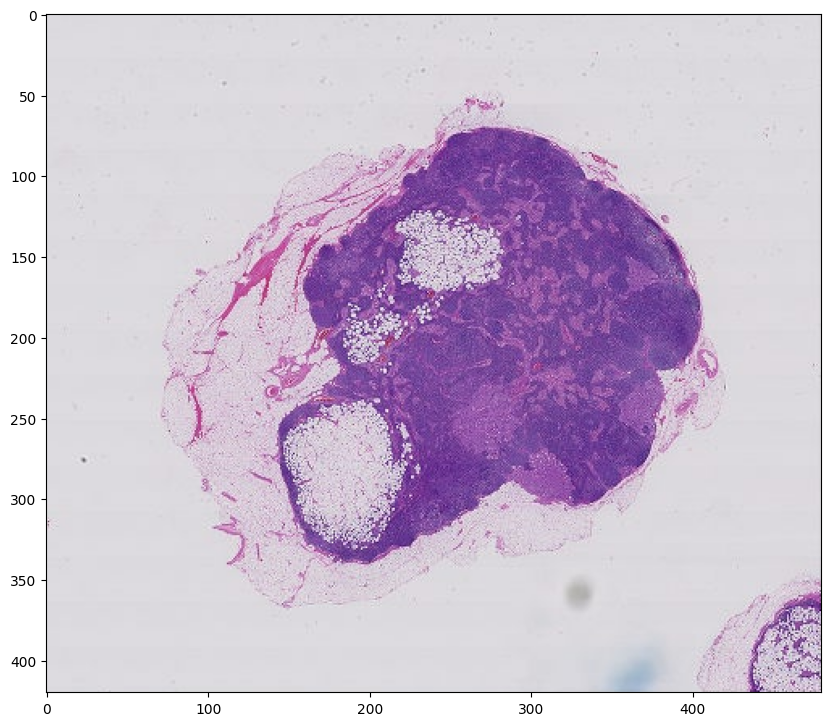

In [ ]:
# Example: read the entire slide at level 5

# Higher zoom levels may not fit into memory.
# You can use the below function to extract regions from higher zoom levels 
# without having to read the entire image into ram.

# Use the sliding window approach discussed in class to collect training
# data for your classifier. E.g., slide a window across the slide (for
# starters, use a zoomed out view, so you're not working with giant images).
# Save each window to disk as an image. To find the label for that image, 
# check to the tissue mask to see if the same region contains cancerous cells.

# Important: this is tricky to get right. Carefully debug your pipeline before
# training your model. Start with just a single image, and a relatively 
# low zoom level.

slide_image = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=7, 
                         width=slide.level_dimensions[7][0], 
                         height=slide.level_dimensions[7][1])

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)

#womt be able to display for more zoomed in

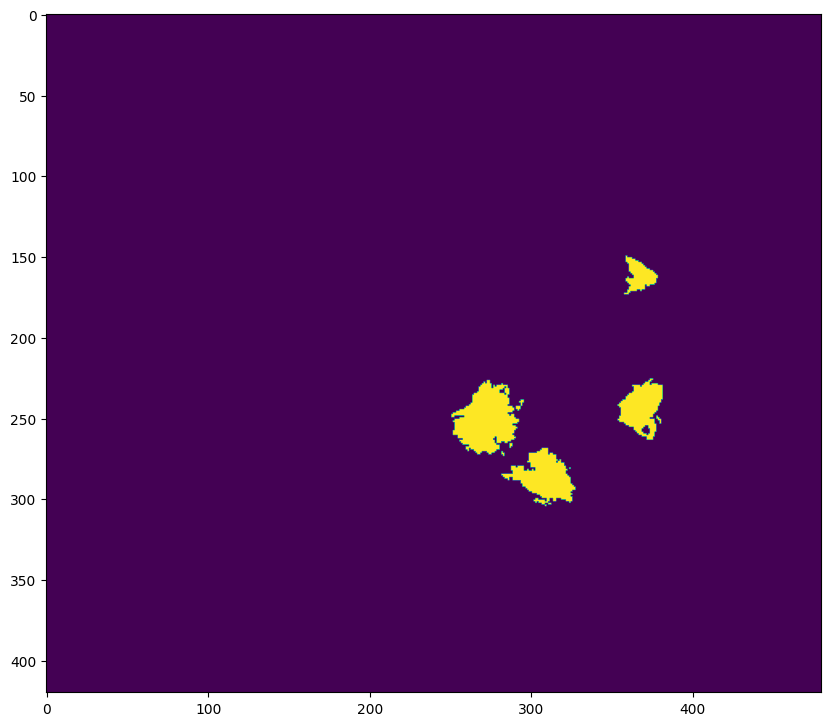

In [ ]:
# Example: read the entire mask at the same zoom level
mask_image = read_slide(tumor_mask, 
                        x=0, 
                        y=0, 
                        level=7, 
                        width=slide.level_dimensions[7][0], 
                        height=slide.level_dimensions[7][1])

# Note: the program provided by the dataset authors generates a mask with R,G,B channels.
# The mask info we need is in the first channel only.
# If you skip this step, the mask will be displayed as all black.
mask_image = mask_image[:,:,0]

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(mask_image)

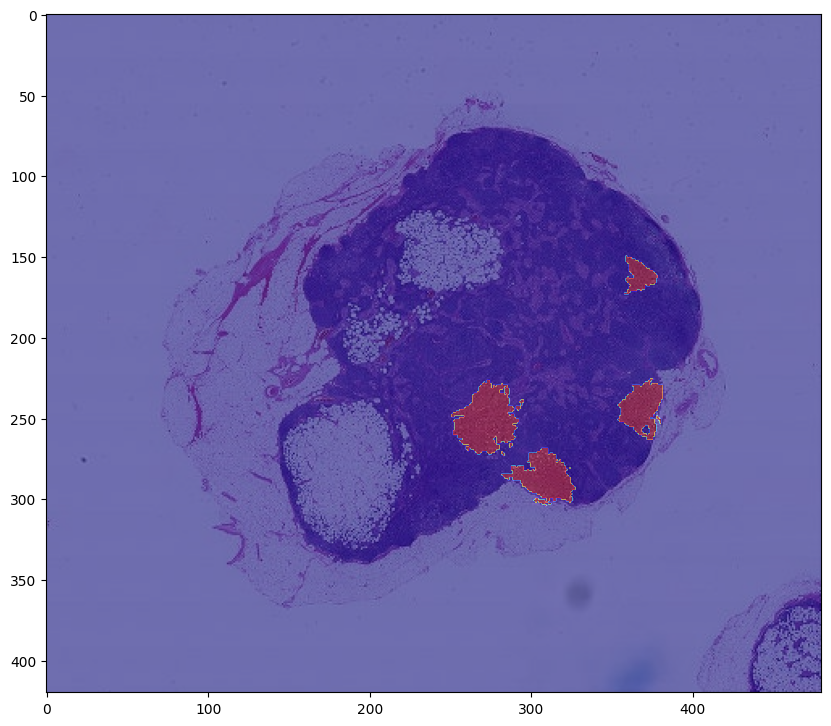

In [ ]:
# Overlay them. The idea is that the mask shows the region of the slide that
# contain cancerous cells.
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)
plt.imshow(mask_image, cmap='jet', alpha=0.5) # Red regions contains cancer.

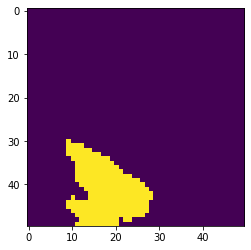

In [ ]:
# Example: extract a region from the L7 downsampled image
# Notice we're multiplying the x,y coordinates by the downsample factor.
# This math can be tricky to get right, debug carefully.
# Here, we're "aiming" for the top right blob in the image above.
region = read_slide(tumor_mask, x=350 * 128, y=120 * 128, level=7, width=50, height=50)[:,:,0]
plt.imshow(region)

#to extract the grid (for level 0 1 etc) use a for loops with this

In [ ]:
# As mentioned in class, we can improve efficiency by ignoring non-tissue areas 
# of the slide. We'll find these by looking for all gray regions.

# skip grey and dont put in training data. for train and classification 
def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return list(zip(indices[0], indices[1]))

tissue_pixels = find_tissue_pixels(slide_image)
percent_tissue = len(tissue_pixels) / float(slide_image.shape[0] * slide_image.shape[0]) * 100
print ("%d tissue_pixels pixels (%.1f percent of the image)" % (len(tissue_pixels), percent_tissue)) 

def apply_mask(im, mask, color=(255,0,0)):
    masked = np.copy(im)
    for x,y in mask: masked[x][y] = color
    return masked

tissue_regions = apply_mask(slide_image, tissue_pixels)
plt.imshow(tissue_regions)

NameError: ignored

for slide level 5. 1920w x 1680h, move a 80x80 window across the slide. Check the center of the slide, 60x60 center window. 

Consider the slide as a tissue slide if >20% of it is tissue.
For tissue slides, check the values in tumor mask. If there is tumor (1) then add it to list of tumor cells.

In [ ]:
slide

OpenSlide('tumor_091.tif')

In [ ]:
print(width, height)

480 420


In [ ]:
window_size = (80, 80)
center_size = (60, 60)

In [ ]:
factor = int(slide.level_downsamples[5])
factor

32

In [ ]:
tumor_mask

OpenSlide('tumor_091_mask.tif')

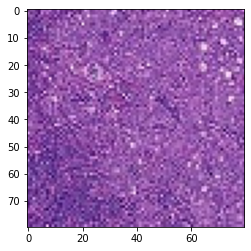

In [ ]:
region = read_slide(slide, x=1000 * 32, y=1000 * 32, level=5, width=window_size[0], height=window_size[1])
plt.imshow(region)

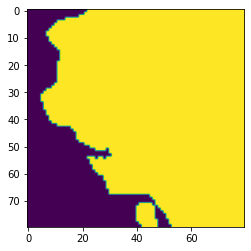

In [ ]:
mask_region = read_slide(tumor_mask, x=1000 * 32, y=1000 * 32, level=5, width=window_size[0], height=window_size[1])[:,:,0]
plt.imshow(mask_region)

In [ ]:
print(len(healthy_grids))
print(len(tumor_grids))

269
14


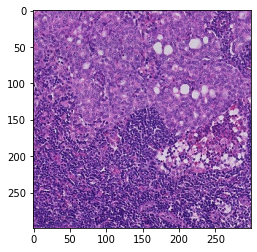

In [ ]:
plt.imshow(tumor_grids[4])

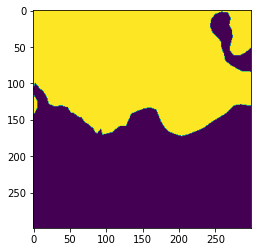

In [ ]:
plt.imshow(mask_centers[4])

### Given Functions

In [ ]:
# See https://openslide.org/api/python/#openslide.OpenSlide.read_region
# Note: x,y coords are with respect to level 0.
# There is an example below of working with coordinates
# with respect to a higher zoom level.

# Read a region from the slide
# Return a numpy RBG array
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

In [ ]:
# As mentioned in class, we can improve efficiency by ignoring non-tissue areas 
# of the slide. We'll find these by looking for all gray regions.

# skip grey and dont put in training data. for train and classification 
def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return list(zip(indices[0], indices[1]))

def apply_mask(im, mask, color=(255,0,0)):
    masked = np.copy(im)
    for x,y in mask: masked[x][y] = color
    return masked

### Split patches into pos and neg for 2 zoom levels

In [ ]:
def get_centered_patch(slide, tumor_mask, x, y, zoom_level, size = 299):
  # get patch of slide and mask centered at x, y in terms of zoom0 coordinates
  x = int(x)
  y = int(y)
  factor = slide.level_downsamples[zoom_level]
  diff = int(int(size/2) * factor)
  slide_patch = read_slide(slide, x - diff, y - diff, zoom_level, width=size, height= size)
  mask_patch = read_slide(tumor_mask, x - diff, y - diff, zoom_level, width=size, height=size)[:, :, 0]
  return slide_patch, mask_patch

Example of method with one slide

In [ ]:
#slide number 96
slide_path = train_slide_paths[2]
slide = open_slide(slide_path)

tumor_path = train_mask_paths[2]
tumor_mask = open_slide(tumor_path)

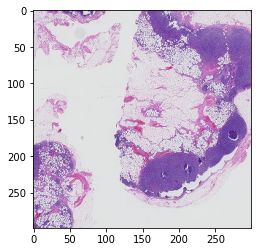

In [ ]:
region = read_slide(slide, 120 * 128, 120 * 128, 7, 299, 299)
plt.imshow(region)

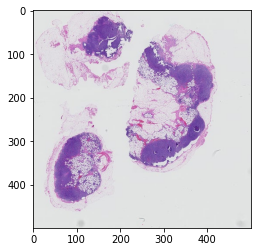

In [ ]:
region2, mask = get_centered_patch(slide, tumor_mask, (120 + 299//2) * 128, (120 + 299//2) * 128, 7, 500)
plt.imshow(region2)

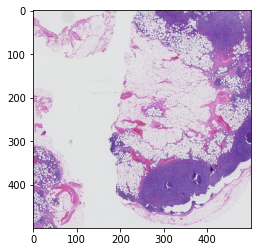

In [ ]:
region2, mask = get_centered_patch(slide, tumor_mask, (120 + 299//2) * 128, (120 + 299//2) * 128, 6, 500)
plt.imshow(region2)

In [ ]:
def generate_patches(slide, tumor_mask, zoom_level1, zoom_level2, patch_size=299, center_size=128):
  #zoom level 1 is higher zoom
  zoom1_p1 = []
  zoom1_p0 = []
  zoom2_p1 = []
  zoom2_p0 = []
  centers = []

  #for first zoom level:
  image_width1, image_height1 = slide.level_dimensions[zoom_level1]
  factor_1 = int(slide.level_downsamples[zoom_level1])
  for i in range(0, image_width1, patch_size):
    for j in range(0, image_height1, patch_size):
      

      center_x_0 = (i + (patch_size // 2)) * factor_1
      center_y_0 = (j + (patch_size // 2)) * factor_1

      patch1, mask1 = get_centered_patch(slide, tumor_mask, center_x_0, center_y_0, zoom_level1, patch_size)
      
      tissue_pixels = find_tissue_pixels(patch1)
      percent_tissue = len(tissue_pixels) / float(patch1.shape[0] * patch1.shape[1]) * 100

      #only keep slides with more than 20% tissue
      if percent_tissue > 20:
        
        #second zoom level. to make faster
        patch2, mask2 = get_centered_patch(slide, tumor_mask, center_x_0, center_y_0, zoom_level2, patch_size)
        #check if tumor in center
        mask_patch = read_slide(tumor_mask, 
                                x = (i + (patch_size - center_size) // 2) * factor_1, 
                                y = (j + (patch_size - center_size) // 2) * factor_1, 
                                level = zoom_level1, width = center_size, height = center_size)[:,:,0]
        
        if np.sum(mask_patch) > 0:
          zoom1_p1.append(patch1)
          zoom2_p1.append(patch2)
        
        else:
          zoom1_p0.append(patch1)
          zoom2_p0.append(patch2)
  
  assert len(zoom1_p1) == len(zoom2_p1)
  assert len(zoom1_p0) == len(zoom2_p0) 

  return zoom1_p1, zoom1_p0, zoom2_p1, zoom2_p0




In [ ]:
# z1pos, z1neg, z2pos, z2neg = generate_patches(slide, tumor_mask, 3, 5)

### Balance data, Load to drive

Data is unbalanced, much more normal compared to tumor

In [ ]:
def combine_balance(train_slide_paths, train_mask_paths, zoom1, zoom2):
  #combine into positive patches and negative patches. Upload these 2 arrays into drive
  

  for i in range(len(train_slide_paths)):
    print("working on slide:", i)
    slide_path = train_slide_paths[i]
    mask_path = train_mask_paths[i]
    
    slide = open_slide(slide_path)
    tumor_mask = open_slide(mask_path)

    zoom1_pos, zoom1_neg, zoom2_pos, zoom2_neg = generate_patches(slide, tumor_mask, zoom1, zoom2)

    #balancing
    num_pos_patches = len(zoom1_pos)
    num_neg_patches = len(zoom1_neg)
    if num_neg_patches >= num_pos_patches:
      idx = np.random.choice(np.arange(len(zoom1_neg)), num_pos_patches, replace=False)
      zoom1_neg_bal = []
      zoom1_pos_bal = zoom1_pos
      zoom2_neg_bal = []
      zoom2_pos_bal = zoom2_pos

      for index in idx:
        zoom1_neg_bal.append(zoom1_neg[index])
        zoom2_neg_bal.append(zoom2_neg[index])
    else:
      idx = np.random.choice(np.arange(len(zoom1_pos)), num_neg_patches, replace=False)
      zoom1_pos_bal = []
      zoom1_neg_bal = zoom1_neg
      zoom2_pos_bal = []
      zoom2_neg_bal = zoom2_neg
      for index in idx:
        zoom1_pos_bal.append(zoom1_pos[index])
        zoom2_pos_bal.append(zoom2_pos[index])
    
    #initializing 
    if i == 0:
      all_z1_pos = zoom1_pos_bal
      all_z1_neg = zoom1_neg_bal
      all_z2_pos = zoom2_pos_bal
      all_z2_neg = zoom2_neg_bal
    
    else:  
      all_z1_pos = np.concatenate((all_z1_pos, zoom1_pos_bal))
      all_z1_neg = np.concatenate((all_z1_neg, zoom1_neg_bal))

      all_z2_pos = np.concatenate((all_z2_pos, zoom2_pos_bal))
      all_z2_neg = np.concatenate((all_z2_neg, zoom2_neg_bal))

  return all_z1_pos, all_z1_neg, all_z2_pos, all_z2_neg

In [ ]:
# create the patches
all_z1_1, all_z1_0, all_z2_1, all_z2_0 = combine_balance(train_slide_paths, train_mask_paths, 2, 3)

working on slide: 0
working on slide: 1
working on slide: 2
working on slide: 3


In [ ]:
assert np.array(all_z1_1).shape == np.array(all_z2_1).shape
assert np.array(all_z1_1).shape == np.array(all_z1_0).shape
assert np.array(all_z1_1).shape == np.array(all_z2_0).shape

In [ ]:
all_z1_pos = np.array(all_z1_1)
all_z1_neg = np.array(all_z1_0)
all_z2_pos = np.array(all_z2_1)
all_z2_neg = np.array(all_z2_0)

In [ ]:
all_z1_pos.shape

(1821, 299, 299, 3)

In [ ]:
all_z1_neg.shape

(1821, 299, 299, 3)

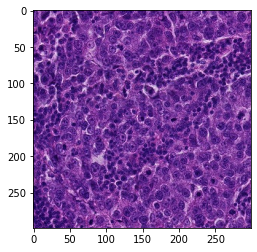

In [ ]:
plt.imshow(all_z1_pos[5])

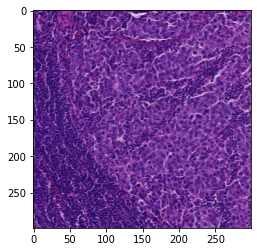

In [ ]:
plt.imshow(all_z2_pos[5])

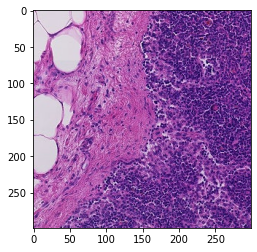

In [ ]:
plt.imshow(all_z2_neg[10])

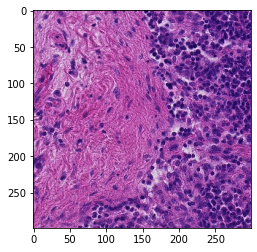

In [ ]:
plt.imshow(all_z1_neg[10])

save onto google drive

In [ ]:
patch_folder = '/content/drive/My Drive/Columbia/DL/final/patches'
np.save(os.path.join(patch_folder) + '/zoom1pos.npy', all_z1_pos)
np.save(os.path.join(patch_folder) + '/zoom2pos.npy', all_z2_pos)
np.save(os.path.join(patch_folder) + '/zoom1neg.npy', all_z1_neg)
np.save(os.path.join(patch_folder) + '/zoom2neg.npy', all_z1_neg)

# Part 2: Model

In [ ]:
all_z1_pos = np.load('/content/drive/My Drive/Columbia/DL/final/patches/zoom1pos.npy')
all_z2_pos = np.load('/content/drive/My Drive/Columbia/DL/final/patches/zoom2pos.npy')
all_z1_neg = np.load('/content/drive/My Drive/Columbia/DL/final/patches/zoom1neg.npy')
all_z2_neg = np.load('/content/drive/My Drive/Columbia/DL/final/patches/zoom2neg.npy')

## Train Val Split

In [ ]:
def train_val_split(zoom1_pos, zoom1_neg, zoom2_pos, zoom2_neg, percent_train=0.8):
  
  #combines into X, y for each zoom then splits into train and validation grids
  num_pos_patches = len(zoom1_pos)
  idx = np.random.choice(np.arange(len(zoom1_neg)), num_pos_patches, replace=False)
  zoom1_pos_bal = zoom1_pos[idx]
  zoom2_pos_bal = zoom2_pos[idx]

  #split train val
  X_z1 = np.concatenate((zoom1_pos_bal, zoom1_neg))
  X_z2 = np.concatenate((zoom2_pos_bal, zoom2_neg))
  labels = np.concatenate((np.ones(num_pos_patches), np.zeros(num_pos_patches)))

  z1_X_train, z1_X_test, z1_y_train, z1_y_test = train_test_split(X_z1, labels, test_size=0.20, random_state=42)
  z2_X_train, z2_X_test, z2_y_train, z2_y_test = train_test_split(X_z2, labels, test_size=0.20, random_state=42)

  return z1_X_train, z1_X_test, z2_X_train, z2_X_test, z1_y_train, z1_y_test


In [ ]:
X_train1, X_test1, X_train2, X_test2, label_train, label_test = train_val_split(all_z1_pos, all_z1_neg, all_z2_pos, all_z2_neg)

## Model design

In [ ]:
def create_model(patch_size=299):
  inception_zoom1 = InceptionV3(weights='imagenet',
                                    include_top=False,
                                    input_shape=(patch_size, patch_size, 3))

  inception_zoom2 = InceptionV3(weights='imagenet',
                                      include_top=False,
                                      input_shape=(patch_size, patch_size, 3))

  inception_zoom1.trainable = False
  inception_zoom2.trainable = False

  input_zoom1 = Input(shape=(patch_size, patch_size, 3))
  input_zoom2 = Input(shape=(patch_size, patch_size, 3))

  model_zoom1 = Sequential()
  model_zoom1.add(inception_zoom1)
  model_zoom1.add(GlobalAveragePooling2D())

  model_zoom2 = Sequential()
  model_zoom2.add(inception_zoom2)
  model_zoom2.add(GlobalAveragePooling2D())

  
  encoded_zoom1 = model_zoom1(input_zoom1)
  encoded_zoom2 = model_zoom2(input_zoom2)

  merged = concatenate([encoded_zoom1, encoded_zoom2])
  dense1 = Dense(126, activation='relu')(merged)
  drop_layer = Dropout(0.5)(dense1)
  dense2 = Dense(126, activation='relu')(drop_layer)

  output = Dense(1, activation='sigmoid')(dense2)
  model = Model(inputs=[input_zoom1, input_zoom2], outputs=output)

  return model

In [ ]:
model = create_model()
model.summary()

87916544/87910968 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 2048)         21802784    input_3[0][0]                    
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 2048)         21802784    input_4[0][0]                    
_____________________________

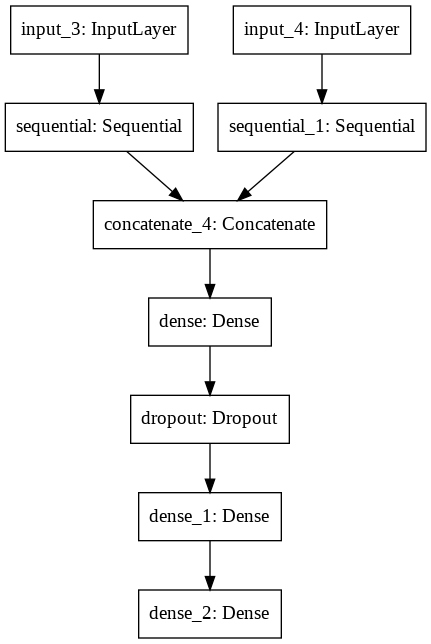

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')

#### Data Augmentation: ISSUE

In [ ]:
# Define the image transformations here
batch_size = 32

train_gen = ImageDataGenerator(horizontal_flip = True,
                               vertical_flip = True,
                               rescale=1./255,
                               width_shift_range=(-8, 8),
                               height_shift_range=(-8, 8),
                               rotation_range = 90) 

val_gen = ImageDataGenerator(rescale=1./255)

def double_train_gen(X1, X2, Y, random_seed = 123):
    genX1 = train_gen.flow(X1,Y, seed = random_seed, batch_size=batch_size)
    genX2 = train_gen.flow(X2, seed = random_seed, batch_size=batch_size)
    while True:
      x1i = genX1.next()
      x2i = genX2.next()
      yield [x1i[0], x2i], x1i[1]

def val_gen_for_two(X1, X2, Y, random_seed = 123):
    genX1 = val_gen.flow(X1,Y, seed = random_seed, batch_size=batch_size)
    genX2 = val_gen.flow(X2, seed = random_seed, batch_size=batch_size)
    while True:
      x1i = genX1.next()
      x2i = genX2.next()
      yield [x1i[0], x2i], x1i[1]

In [ ]:
train_flow = double_train_gen(X_train1, X_train2, label_train)
val_flow = val_gen_for_two(X_test1, X_test2, label_test)

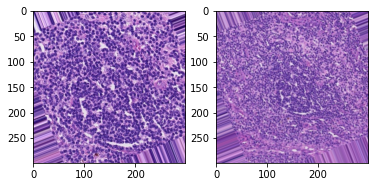

In [ ]:
counter = 0
for x, y in train_flow:
  plt.subplot(1, 2, 1)
  plt.imshow(x[0][5])
  plt.subplot(1, 2, 2)
  plt.imshow(x[1][5])
  if counter == 0:
    break

checkpoints

In [ ]:
# Mount drive
drive.mount('/gdrive')
drive_root = '/gdrive/My Drive/'

Mounted at /gdrive


In [ ]:
checkpoint_dir = os.path.join(drive_root, "Columbia/DL/final/checkpoints")
checkpoint_dir = os.path.join(checkpoint_dir, "project")
checkpoint_path = os.path.join(checkpoint_dir, "weights-{epoch:02d}.hdf5")

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True, monitor='val_accuracy',
                                                 verbose=1)

In [ ]:
#delete later
print("Checkpoints directory is", checkpoint_dir)
if os.path.exists(checkpoint_dir):
  print("Checkpoints folder already exists")
else:
  print("Creating a checkpoints directory")
  os.makedirs(checkpoint_dir)

Checkpoints directory is /gdrive/My Drive/Columbia/DL/final/checkpoints/project
Creating a checkpoints directory


In [ ]:
model = create_model()

model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit_generator(train_flow,
                              epochs=5,
                              validation_data=val_flow, 
                              steps_per_epoch = len(z1_X_train) / batch_size, 
                              validation_steps=len(z1_X_test) / batch_size,
                              callbacks = [cp_callback])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
25/25 [==============================] - 44s 1s/step - loss: 0.6744 - accuracy: 0.6046 - val_loss: 0.5624 - val_accuracy: 0.7980

Epoch 00001: saving model to /gdrive/My Drive/Columbia/DL/final/checkpoints/project/weights-01-0.80.hdf5
Epoch 2/5
25/25 [==============================] - 30s 1s/step - loss: 0.5235 - accuracy: 0.7521 - val_loss: 0.4822 - val_accuracy: 0.8030

Epoch 00002: saving model to /gdrive/My Drive/Columbia/DL/final/checkpoints/project/weights-02-0.80.hdf5
Epoch 3/5
25/25 [==============================] - 30s 1s/step - loss: 0.4362 - accuracy: 0.8051 - val_loss: 0.3942 - val_accuracy: 0.8670

Epoch 00003: saving model to /gdrive/My Drive/Columbia/DL/final/checkpoints/project/weights-03-0.87.hdf5
Epoch 4/5
25/25 [==============================] - 31s 1s/step - loss: 0.4009 - accuracy: 0.8300 - val_loss: 0.4398 - val_accuracy: 0.7635

Epoch 00004: saving model to /gdrive/My Drive/Columbia/DL/final/checkpoints/project/weights-04-0.76.hdf5
Epoch 5/5
25/25 [===

### Fit model - No augmentation

In [ ]:
batch_size = 32
model = create_model()
# compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = model.fit([X_train1, X_train2], label_train, batch_size = 32, epochs = 10, validation_data=([X_test1, X_test2], label_test))

Epoch 1/10
92/92 [==============================] - 42s 203ms/step - loss: 2.7348 - accuracy: 0.6791 - val_loss: 0.4431 - val_accuracy: 0.8724
Epoch 2/10
92/92 [==============================] - 15s 163ms/step - loss: 0.6202 - accuracy: 0.8053 - val_loss: 0.3591 - val_accuracy: 0.8807
Epoch 3/10
92/92 [==============================] - 15s 164ms/step - loss: 0.4085 - accuracy: 0.8497 - val_loss: 0.3054 - val_accuracy: 0.8601
Epoch 4/10
92/92 [==============================] - 15s 164ms/step - loss: 0.3434 - accuracy: 0.8673 - val_loss: 0.2914 - val_accuracy: 0.8738
Epoch 5/10
92/92 [==============================] - 15s 164ms/step - loss: 0.3497 - accuracy: 0.8622 - val_loss: 0.2837 - val_accuracy: 0.8779
Epoch 6/10
92/92 [==============================] - 15s 163ms/step - loss: 0.3505 - accuracy: 0.8558 - val_loss: 0.2784 - val_accuracy: 0.8779
Epoch 7/10
92/92 [==============================] - 15s 163ms/step - loss: 0.3009 - accuracy: 0.8714 - val_loss: 0.2780 - val_accuracy: 0.8752

In [ ]:
model.save("/content/best_model_noaug.h5")

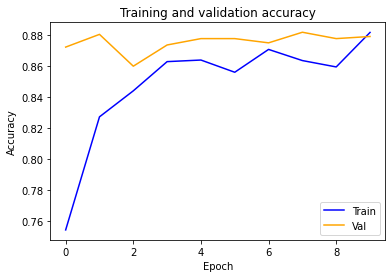

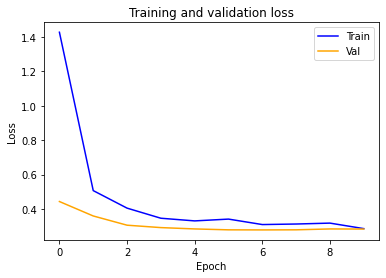

In [ ]:
def plot(history):
  
  # The history object contains results on the training and test
  # sets for each epoch
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  # Get the number of epochs
  epochs = range(len(acc))

  plt.title('Training and validation accuracy')
  plt.plot(epochs, acc, color='blue', label='Train')
  plt.plot(epochs, val_acc, color='orange', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()

  _ = plt.figure()
  plt.title('Training and validation loss')
  plt.plot(epochs, loss, color='blue', label='Train')
  plt.plot(epochs, val_loss, color='orange', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  
plot(history)

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#testing what model predicts on training data
# counter = 0
# for i in range(len(all_z1_pos)):
#   s1 = all_z1_pos[i].reshape(1, 299, 299, 3)
#   s2 = all_z2_pos[i].reshape(1, 299, 299, 3)
#   print(model.predict([s1, s2]))
#   counter += 1
#   if counter == 20:
#     break

[[0.8604757]]
[[0.45151982]]
[[0.67420226]]
[[0.67304087]]
[[0.99084586]]
[[0.9488267]]
[[0.8836945]]
[[0.68292874]]
[[0.39156398]]
[[0.8157197]]
[[0.9456195]]
[[0.968971]]
[[0.99665314]]
[[0.7564485]]
[[0.42668486]]
[[0.43687946]]
[[0.14370087]]
[[0.28773817]]
[[0.6865209]]
[[0.9975611]]


## Predictions

In [ ]:
def predict(slide, tumor_mask, zoom_level1, zoom_level2, patch_size=299, center_size=128, result_level=7, threshold=0.5):
  #zoom level 1 is higher zoom
  
  predictions = []
  labels = []

  image_w = slide.level_dimensions[result_level][0]
  image_h = slide.level_dimensions[result_level][1]

  slide_image = read_slide(slide, 
                             x=0, 
                             y=0, 
                             level=result_level, 
                             width=image_w, 
                             height=image_h)
  
  predicted_mask = np.zeros((slide_image.shape[0], slide_image.shape[1]))

  #for first zoom level:
  image_width1, image_height1 = slide.level_dimensions[zoom_level1]

  factor_1 = int(slide.level_downsamples[zoom_level1])

  for i in range(0, image_width1, patch_size):
    for j in range(0, image_height1, patch_size):
      
      center_x_0 = (i + (patch_size // 2)) * factor_1
      center_y_0 = (j + (patch_size // 2)) * factor_1
      
      patch1, mask1 = get_centered_patch(slide, tumor_mask, center_x_0, center_y_0, zoom_level1, patch_size)
      
      #can introduce rotations later and then have average of those

      tissue_pixels = find_tissue_pixels(patch1)      
      percent_tissue = len(tissue_pixels) / float(patch1.shape[0] * patch1.shape[1]) * 100
      
      if percent_tissue > 20:

        patch2, mask2 = get_centered_patch(slide, tumor_mask, center_x_0, center_y_0, zoom_level2, patch_size)
        
        pred = model.predict([patch1.reshape(1, patch_size, patch_size, 3), patch2.reshape(1, patch_size, patch_size, 3)])

        predictions.append(pred[0][0])
        if np.mean(pred) > threshold:
        
          row = int(i * factor_1 / slide.level_downsamples[result_level])
          col = int(j * factor_1 / slide.level_downsamples[result_level])

          dist = int(patch_size * factor_1 / slide.level_downsamples[result_level])

          predicted_mask[col:col+dist , row:row+dist] = 1
    
    
    total_blocks = int(image_width1 / patch_size)

    tracker = int(i / patch_size)
    if tracker % 10 == 0:
      
      print(f"Progress: {tracker} / {total_blocks}")

  return predicted_mask



In [ ]:
def evaluation_scores(pred_array, test_slide, test_mask, level=7):
    actual_array = read_slide(test_mask, 0, 0, 7, test_mask.level_dimensions[7][0], test_mask.level_dimensions[7][1])[:,:,0]
    
    total_tn = 0
    total_fp = 0
    total_fn = 0
    total_tp = 0
    for i in range(len(actual_array)):
        y_true = actual_array[i]
        y_pred = pred_array[i]

        tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
        total_tn += tn
        total_fp += fp
        total_fn += fn
        total_tp += tp
    
    
    accuracy = (total_tp + total_tn) / (total_tp + total_tn + total_fp + total_fn)
    precision = total_tp / (total_tp + total_fp)
    recall = total_tp / (total_tp + total_fn)
    f1 = 2 * (precision * recall) / (precision + recall)

    print('accuracy: ', accuracy)
    print('precision: ', precision)
    print('recall: ', recall)
    print('F-1 Score: ', f1)
    
    return 

### Paramter Tuning

In [ ]:
train_slide_paths

['/content/drive/My Drive/Columbia/DL/final/slides/tumor_078.tif',
 '/content/drive/My Drive/Columbia/DL/final/slides/tumor_084.tif',
 '/content/drive/My Drive/Columbia/DL/final/slides/tumor_096.tif',
 '/content/drive/My Drive/Columbia/DL/final/slides/tumor_110.tif']

#### Train slide 84

In [ ]:
train_mask_84 = open_slide(train_mask_paths[1])
train_slide_84 = open_slide(train_slide_paths[1])

In [ ]:
pred_84 = predict(train_slide_84, train_mask_84, 2, 3, threshold=0.6)

Progress: 0 / 54
Progress: 10 / 54
Progress: 20 / 54
Progress: 30 / 54
Progress: 40 / 54
Progress: 50 / 54


In [ ]:
pred_84_7 = predict(train_slide_84, train_mask_84, 2, 3, threshold=0.7)

Progress: 0 / 54
Progress: 10 / 54
Progress: 20 / 54
Progress: 30 / 54
Progress: 40 / 54
Progress: 50 / 54


Text(0.5, 1.0, 'predicted mask 0.7')

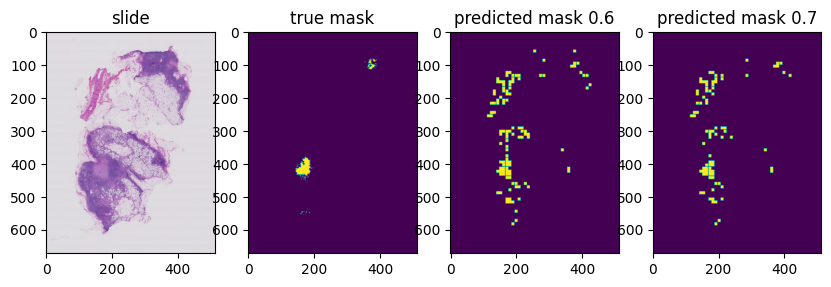

In [ ]:
slide_84 = read_slide(train_slide_84, 0, 0, 7, train_slide_84.level_dimensions[7][0], train_slide_84.level_dimensions[7][1])
true_mask_84 = read_slide(train_mask_84, 0, 0, 7, train_mask_84.level_dimensions[7][0], train_mask_84.level_dimensions[7][1])[:,:,0]

plt.figure(figsize = (10,20), dpi = 100)

plt.subplot(1, 4, 1)
plt.imshow(slide_84)
plt.title("slide")

plt.subplot(1, 4, 2)
plt.imshow(true_mask_84)
plt.title("true mask")

plt.subplot(1, 4, 3)
plt.imshow(pred_84)
plt.title("predicted mask 0.6")

plt.subplot(1, 4, 4)
plt.imshow(pred_84_7)
plt.title("predicted mask 0.7")

In [ ]:
evaluation_scores(pred_84, train_slide_84, train_mask_84)

accuracy:  0.9750744047619048
precision:  0.14974457215836526
recall:  0.705616850551655
F-1 Score:  0.24705882352941175


In [ ]:
evaluation_scores(pred_84_7, train_slide_84, train_mask_84)

accuracy:  0.9813552129836309
precision:  0.18632042003689514
recall:  0.6584754262788365
F-1 Score:  0.29045459573056076


#### Train slide 110

In [ ]:
train_mask_110 = open_slide(train_mask_paths[3])
train_slide_110 = open_slide(train_slide_paths[3])

In [ ]:
pred_110_6 = predict(train_slide_110, train_mask_110, 2, 3, threshold=0.6)

Progress: 0 / 78
Progress: 10 / 78
Progress: 20 / 78
Progress: 30 / 78
Progress: 40 / 78
Progress: 50 / 78
Progress: 60 / 78
Progress: 70 / 78


In [ ]:
pred_110_7 = predict(train_slide_110, train_mask_110, 2, 3, threshold=0.7)

Progress: 0 / 78
Progress: 10 / 78
Progress: 20 / 78
Progress: 30 / 78
Progress: 40 / 78
Progress: 50 / 78
Progress: 60 / 78
Progress: 70 / 78


Text(0.5, 1.0, 'predicted mask 0.7')

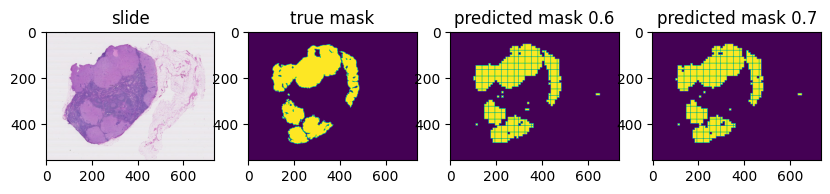

In [ ]:
slide_110 = read_slide(train_slide_110, 0, 0, 7, train_slide_110.level_dimensions[7][0], train_slide_110.level_dimensions[7][1])
true_mask_110 = read_slide(train_mask_110, 0, 0, 7, train_mask_110.level_dimensions[7][0], train_mask_110.level_dimensions[7][1])[:,:,0]

plt.figure(figsize = (10,20), dpi = 100)

plt.subplot(1, 4, 1)
plt.imshow(slide_110)
plt.title("slide")

plt.subplot(1, 4, 2)
plt.imshow(true_mask_110)
plt.title("true mask")

plt.subplot(1, 4, 3)
plt.imshow(pred_110_6)
plt.title("predicted mask 0.6")

plt.subplot(1, 4, 4)
plt.imshow(pred_110_7)
plt.title("predicted mask 0.7")

In [ ]:
evaluation_scores(pred_110_6, train_slide_110, train_mask_110)

accuracy:  0.968257472826087
precision:  0.909785271652976
recall:  0.8840911212771917
F-1 Score:  0.896754184521414


In [ ]:
evaluation_scores(pred_110_7, train_slide_110, train_mask_110)

accuracy:  0.9685098020186336
precision:  0.9215531554634973
recall:  0.8722963931161112
F-1 Score:  0.8962485111553434


Sacrifices recall for better F-1 Score and precision. Going to use 0.7 as my threshold

### Test Slides

In [ ]:
test_slide_paths

['/content/drive/My Drive/Columbia/DL/final/slides/tumor_075.tif',
 '/content/drive/My Drive/Columbia/DL/final/slides/tumor_091.tif',
 '/content/drive/My Drive/Columbia/DL/final/slides/tumor_101.tif']

#### Test slide 75

In [ ]:
test_slide_75 = open_slide(test_slide_paths[0])
test_mask_75 = open_slide(test_mask_paths[0])

In [ ]:
pred_75 = predict(test_slide_75, test_mask_75, 2, 3, patch_size=299, center_size=128, threshold=0.7)

Progress: 0 / 75
Progress: 10 / 75
Progress: 20 / 75
Progress: 30 / 75
Progress: 40 / 75
Progress: 50 / 75
Progress: 60 / 75
Progress: 70 / 75


Text(0.5, 1.0, 'predicted mask')

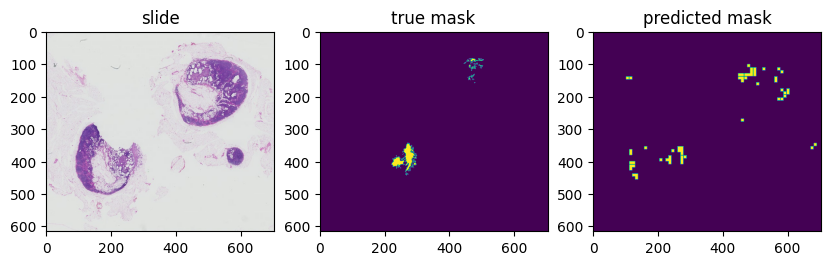

In [ ]:
slide_75 = read_slide(test_slide_75, 0, 0, 7, test_slide_75.level_dimensions[7][0], test_slide_75.level_dimensions[7][1])
true_mask_75 = read_slide(test_mask_75, 0, 0, 7, test_mask_75.level_dimensions[7][0], test_mask_75.level_dimensions[7][1])[:,:,0]

plt.figure(figsize = (10,20), dpi = 100)

plt.subplot(1, 3, 1)
plt.imshow(slide_75)
plt.title("slide")

plt.subplot(1, 3, 2)
plt.imshow(true_mask_75)
plt.title("true mask")

plt.subplot(1, 3, 3)
plt.imshow(pred_75)
plt.title("predicted mask")

In [ ]:
evaluation_scores(pred_75, test_slide_75, test_mask_75)

accuracy:  0.9868861607142857
precision:  0.2130152751621678
recall:  0.34578804347826086
F-1 Score:  0.2636281237860935


#### Test slide 91

In [ ]:
test_slide_91 = open_slide(test_slide_paths[1])
test_mask_91 = open_slide(test_mask_paths[1])

In [ ]:
pred_91_7 = predict(test_slide_91, test_mask_91, 2, 3, patch_size=299, center_size=128, threshold=0.7)

Progress: 0 / 51
Progress: 10 / 51
Progress: 20 / 51
Progress: 30 / 51
Progress: 40 / 51
Progress: 50 / 51


Text(0.5, 1.0, 'predicted mask')

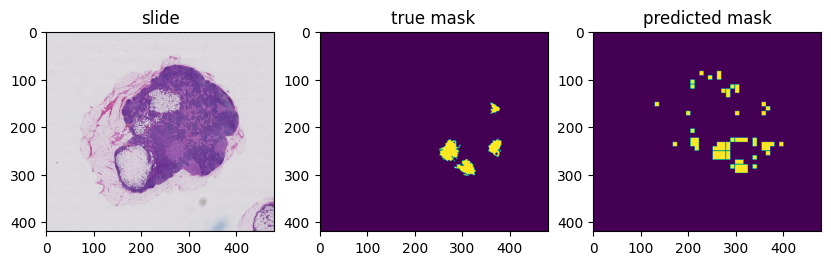

In [ ]:
slide_91 = read_slide(test_slide_91, 0, 0, 7, test_slide_91.level_dimensions[7][0], test_slide_91.level_dimensions[7][1])
true_mask_91 = read_slide(test_mask_91, 0, 0, 7, test_mask_91.level_dimensions[7][0], test_mask_91.level_dimensions[7][1])[:,:,0]

plt.figure(figsize = (10,20), dpi = 100)

plt.subplot(1, 3, 1)
plt.imshow(slide_91)
plt.title("slide")

plt.subplot(1, 3, 2)
plt.imshow(true_mask_91)
plt.title("true mask")

plt.subplot(1, 3, 3)
plt.imshow(pred_91_7)
plt.title("predicted mask")

In [ ]:
evaluation_scores(pred_91_7, test_slide_91, test_mask_91)

accuracy:  0.9815575396825397
precision:  0.4234182098765432
recall:  0.7506839945280438
F-1 Score:  0.5414405525407006


#### Test slide 101

In [ ]:
test_slide_101 = open_slide(test_slide_paths[2])
test_mask_101 = open_slide(test_mask_paths[2])

In [ ]:
pred_101 = predict(test_slide_101, test_mask_101, 2, 3, patch_size=299, center_size=128, threshold=0.7)

Progress: 0 / 116
Progress: 10 / 116
Progress: 20 / 116
Progress: 30 / 116
Progress: 40 / 116
Progress: 50 / 116
Progress: 60 / 116
Progress: 70 / 116
Progress: 80 / 116
Progress: 90 / 116
Progress: 100 / 116
Progress: 110 / 116


Text(0.5, 1.0, 'predicted mask')

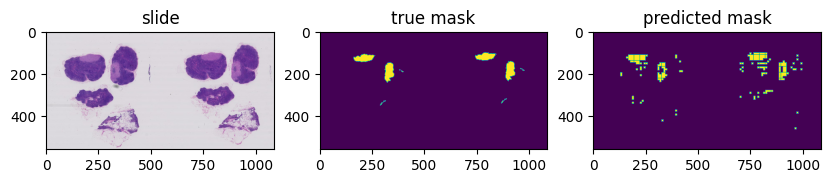

In [ ]:
slide_101 = read_slide(test_slide_101, 0, 0, 7, test_slide_101.level_dimensions[7][0], test_slide_101.level_dimensions[7][1])
true_mask_101 = read_slide(test_mask_101, 0, 0, 7, test_mask_101.level_dimensions[7][0], test_mask_101.level_dimensions[7][1])[:,:,0]

plt.figure(figsize = (10,20), dpi = 100)

plt.subplot(1, 3, 1)
plt.imshow(slide_101)
plt.title("slide")

plt.subplot(1, 3, 2)
plt.imshow(true_mask_101)
plt.title("true mask")

plt.subplot(1, 3, 3)
plt.imshow(pred_101)
plt.title("predicted mask")

In [ ]:
evaluation_scores(pred_101, test_slide_101, test_mask_101)

accuracy:  0.9835609243697478
precision:  0.5537037037037037
recall:  0.7630146308268119
F-1 Score:  0.6417227071111747
